# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [1]:
import dill as pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import jit, prange

In [2]:
with open(r'D:\ucl\pyssem\scenario_properties_short.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)

In [3]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

# Convert to symbols
print(len(symbols)) # Should be 320 for a 40, 8 matrix
print(symbols)

# Convert equations to lambda functions
equations = [sp.lambdify(symbols, eq, 'numpy') for eq in scenario_properties.equations]

320
[Su_260kg_1, Su_260kg_2, Su_260kg_3, Su_260kg_4, Su_260kg_5, Su_260kg_6, Su_260kg_7, Su_260kg_8, Su_260kg_9, Su_260kg_10, Su_260kg_11, Su_260kg_12, Su_260kg_13, Su_260kg_14, Su_260kg_15, Su_260kg_16, Su_260kg_17, Su_260kg_18, Su_260kg_19, Su_260kg_20, Su_260kg_21, Su_260kg_22, Su_260kg_23, Su_260kg_24, Su_260kg_25, Su_260kg_26, Su_260kg_27, Su_260kg_28, Su_260kg_29, Su_260kg_30, Su_260kg_31, Su_260kg_32, Su_260kg_33, Su_260kg_34, Su_260kg_35, Su_260kg_36, Su_260kg_37, Su_260kg_38, Su_260kg_39, Su_260kg_40, Su_473kg_1, Su_473kg_2, Su_473kg_3, Su_473kg_4, Su_473kg_5, Su_473kg_6, Su_473kg_7, Su_473kg_8, Su_473kg_9, Su_473kg_10, Su_473kg_11, Su_473kg_12, Su_473kg_13, Su_473kg_14, Su_473kg_15, Su_473kg_16, Su_473kg_17, Su_473kg_18, Su_473kg_19, Su_473kg_20, Su_473kg_21, Su_473kg_22, Su_473kg_23, Su_473kg_24, Su_473kg_25, Su_473kg_26, Su_473kg_27, Su_473kg_28, Su_473kg_29, Su_473kg_30, Su_473kg_31, Su_473kg_32, Su_473kg_33, Su_473kg_34, Su_473kg_35, Su_473kg_36, Su_473kg_37, Su_473kg_38,

In [4]:
full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [14]:
print(full_lambda_flattened[100])

None


In [23]:
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

# Initial population needs to be in one columnn, so now the intiial population is in one. Species 1 is the first 40 rows, species 2 is the next 40 rows, etc.
def population_shell(t, N, full_lambda, equations):
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)
    
    # Iterate over each component in N
    for i in range(len(N)):
        # Compute the intrinsic rate of change from the differential equation
        dN_dt[i] = equations[i](*N)

        # Compute and add the external modification rate, if applicable
        # Now using np.interp to calculate the increase
        if full_lambda[i] is not None:
            increase = np.interp(t, times, full_lambda[i])
            dN_dt[i] += increase
    print(N)         
    return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, args=(full_lambda_flattened, equations), t_eval=scenario_properties.scen_times, method='LSODA') #atol=1e-6, rtol=1e-3, max_step=1e-2 

[2.000e+00 2.000e+00 1.100e+01 1.400e+01 3.000e+01 4.300e+01 4.400e+01
 1.170e+02 1.610e+02 2.120e+02 2.650e+02 1.705e+03 1.860e+02 3.100e+01
 2.000e+01 6.000e+00 2.100e+01 2.000e+00 3.000e+00 6.000e+00 1.000e+00
 0.000e+00 1.100e+01 7.000e+00 1.600e+01 4.000e+00 0.000e+00 1.000e+00
 2.000e+00 5.000e+00 0.000e+00 8.000e+00 4.400e+01 2.860e+02 2.800e+01
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00 3.000e+00 4.000e+00
 2.700e+01 2.700e+01 3.000e+00 1.200e+01 3.600e+01 2.800e+01 4.000e+00
 1.400e+01 3.000e+00 9.000e+00 7.500e+01 1.000e+01 0.000e+00 0.000e+00
 3.000e+00 2.000e+00 3.000e+00 0.000e+00 0.000e+00 1.000e+00 1.400e+01
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 2.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.600e+01 9.000e+00 1.100e+01 7.000e+00 1.700e+01 3.400e+01 3.900e+01
 2.400e+01 6.000e+01 6.300e+01 9.300e+01 5.300e+01 7.400e+01 4.100e+01
 6.600

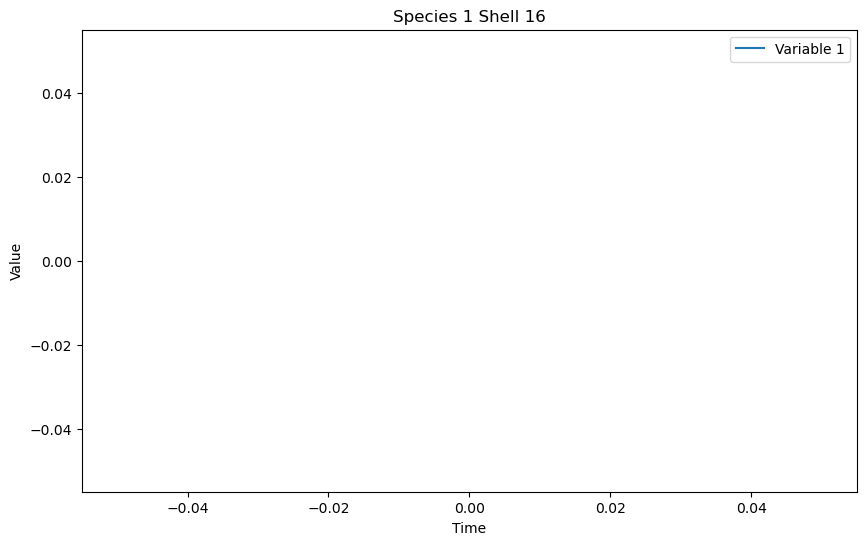

In [17]:
plt.figure(figsize=(10, 6))

# 'output.y' shape is (n_variables, n_timepoints)
# Loop over the first 10 rows (variables) if there are at least 10
n_plots = min(10, output.y.shape[0])

# for i in range(n_plots):
#     plt.plot(output.t, output.y[i, :], label=f'Variable {i+1}')

plt.plot(output.t, output.y[15, :], label='Variable 1')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Species 1 Shell 16')
plt.legend()
plt.show()

D:\TEMP\ipykernel_9284\3150393037.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


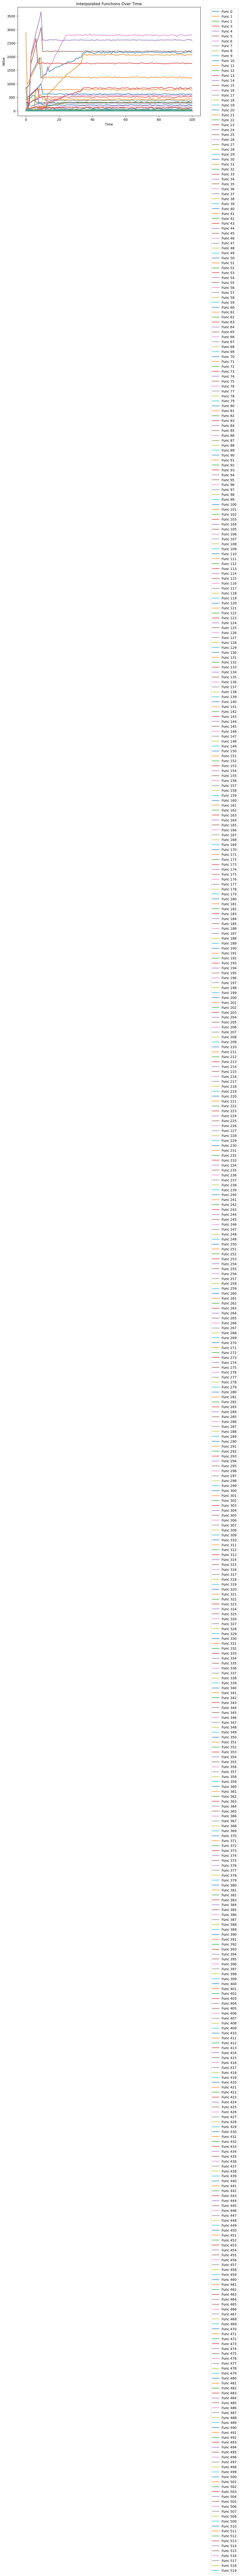

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.scen_times defines the time range for plotting
start_time, end_time = scenario_properties.scen_times[0], scenario_properties.scen_times[-1]
time_points = np.linspace(start_time, end_time, 100)  # Adjust the number of points as necessary

# Filter out None values from the list of interpolated functions
interpolated_functions = [f for f in full_lambda_flattened if f is not None]

# Plot each interpolated function
plt.figure(figsize=(10, 6))
for func in interpolated_functions:
    # Evaluate the function at each point in time_points
    values = func(time_points)
    
    # Plot the result
    plt.plot(time_points, values)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Interpolated Functions Over Time')
plt.legend([f'Func {i}' for i, _ in enumerate(interpolated_functions)], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
interpolated_values = [np.interp(scenario_properties.scen_times, times, fl) if fl is not None else None for fl in full_lambda_flattened]

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
# Assuming times, full_lambda, and equations are defined

# Pre-compute interpolated values for each full_lambda entry
@jit(nopython=True)
def population_shell(t, N, interpolated_values, equations):
    dN_dt = np.zeros_like(N)
    # Find the index in scen_times closest to t
    idx = np.searchsorted(scenario_properties.scen_times, t, side='right') - 1
    
    for i in range(len(N)):
        dN_dt[i] = equations[i](*N)
        if interpolated_values[i] is not None:
            # Use pre-computed value
            increase = interpolated_values[i][idx]
            dN_dt[i] += increase
    
    return dN_dt

# Solve the ODE with pre-computed interpolated values
output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, args=(interpolated_values, equations), t_eval=scenario_properties.scen_times, method='RK45')


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'scenario_properties':[0m [1m[1mCannot determine Numba type of <class 'utils.simulation.scen_properties.ScenarioProperties'>[0m
[1m
File "..\..\..\..\TEMP\ipykernel_16540\659704441.py", line 10:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m 

This error may have been caused by the following argument(s):
- argument 3: Cannot type list element type <class 'function'>
